## Tarea 5
### Olmo Guerrero Medina

1. Mejorar la imagen en falso color
2. Detectar Polvo del Sahara en el Golfo de México

In [1]:
# Required libraries
%matplotlib inline
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
from datetime import datetime
from pyproj import Proj

# Converts the CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)

In [2]:
#reflectance(radiancia, numero de banda): convierte la radiancia a reflectancia las bandas 1-6 de GOES 16
def reflectance(radiance, band):
    Esun_dict = {1:441.868715,2:663.274497,3:726.721072,4:679.143879,5:634.454241,6:381.148813}
    Esun = Esun_dict[band]
    d2 = 0.3
    refl = (radiance * np.pi * d2) / Esun
    refl = np.maximum(refl, 0.0)
    refl = np.minimum(refl, 1.0)
    return refl

# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)


# 1. Imagen en falso color :

In [3]:
path1 ='/home/olmo/Downloads/28062018/OR_ABI-L1b-RadC-M3C01_G16_s20181791802194_e20181791804567_c20181791805015.nc'
nc1 = Dataset(path1)
radiance1 = nc1.variables['Rad'][:]
nc1.close()
refl1 = reflectance(radiance1, band = 1)
    
path2 ='/home/olmo/Downloads/28062018/OR_ABI-L1b-RadC-M3C02_G16_s20181791802194_e20181791804567_c20181791805013.nc'
nc2 = Dataset(path2)
radiance2 = nc2.variables['Rad'][:]
nc2.close()
refl2 = reflectance(radiance2, band = 2)
refl2 = rebin(refl2, [3000,5000])

path3 ='/home/olmo/Downloads/28062018/OR_ABI-L1b-RadC-M3C03_G16_s20181791802194_e20181791804567_c20181791805015.nc'
nc3 = Dataset(path3)
radiance3 = nc3.variables['Rad'][:]
nc3.close()
refl3 = reflectance(radiance3, band = 3)

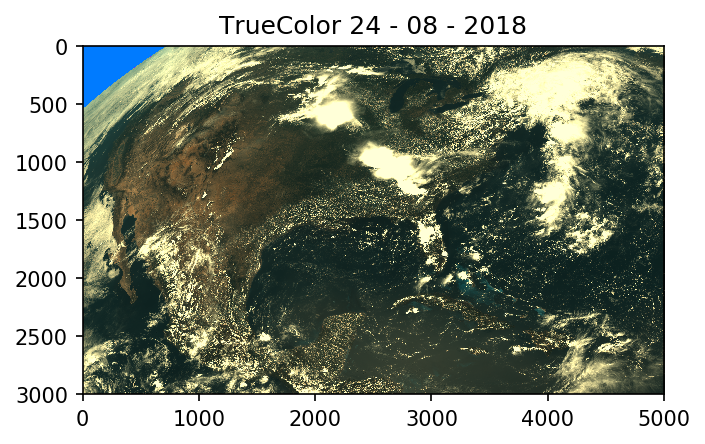

In [4]:
# True Green :
# Derived from Planet Labs data, CC > 0.9
true_green = 0.48358168 * refl2 + 0.45706946 * refl1 + 0.06038137 * refl3
# True Color:
truecolor = np.stack([refl2*2.55, true_green*1.7, refl1*0.85], axis=2)
fig = plt.figure(figsize=(5,5),dpi=150)
im = plt.imshow(truecolor)
plt.title('TrueColor 24 - 08 - 2018')
plt.show()


# 2. Detección de arenas del Sahara en el Golfo de México

El periodo entre el 20 y el 26 de agosto de  2018 muestra eventos de polvo del sahara en el Golfo de México, buscaremos visualizarlos utilizando imagenes de GOES16. Se eligió trabajar inicialmente con el día 24 de agosto, al ser un día intermedio, sin embargo valdría la pena repetir el ejercicio con otros días, horas o eventos. Para poder utilizar bandas con longitudes en el infrarrojo y en el visible se utilizaron los datos del medio día (18:00 UTC) en México. 

Se muestran resultados de una propuesta para visualizar aerosoles de arenas, además de la implementación de distintos métodos descritos en la literatura para poder validar la propuesta.

La imagen superior muestra una composición de canales para el día estudiado, es posible observar una región más tenue entre el sureste mexicano y la isla de Cuba, podría atribuirse a la presencia de aerosoles minerales del Sahara.

## Propuesta:

El canal 1 es bueno para ver aerosoles de día, mientras que el canal 2 es bueno para ver nubes de día, las diferencias entre estos canales podrían proveer una imagen de los aerosoles a la cual se le retiraron las nubes. Lo anterior bajo la idea de que las arenas no son buenos núcleos de condensación, sin embargo sí lo son de cristales de hielo, un intento posterior podría ser quitar las partículas de hielo.

Se observo que normalizando las diferencias se obtenian mejores resultados. Posteriormente se encontró que si a la banda 1 se le retiraban las diferencias normalizadas se obtienen buenos resultados. Lo anterior se sustenta en la idea de que primero se retira la influencia de los aerosoles en las nubes, para poder tener las nubes, posteriormente a los aerosoles se les restan las nubes, matemáticamente :

$B1_n = B1 - \big( \frac{B2 - B1}{B2 + B1}\big)$,

donde $B1_n$ es la banda 1 (B1) tras retirar la influencia del vapor y las nubes de la banda 2(B2).

In [18]:
path = '/home/olmo/Downloads/28062018/OR_ABI-L2-CMIPC-M3C01_G16_s20181791802194_e20181791804567_c20181791805051.nc'
# Search for the Scan Start in the file name
Start = (path[path.find("_s")+2:path.find("_e")-1])
End = (path[path.find("_e")+2:path.find("_c")-1])

# Format the "Observation Start" string
datetime_start = datetime.strptime(Start,'%Y%j%H%M%S')
datetime_end = datetime.strptime(End,'%Y%j%H%M%S')

nc = Dataset(path)
data = nc.variables['CMI'][:]
ori_proj = nc.variables['goes_imager_projection']
# Satellite height
sat_h = ori_proj.perspective_point_height
# Satellite longitude
sat_lon = ori_proj.longitude_of_projection_origin
# Satellite sweep
sat_sweep = ori_proj.sweep_angle_axis
# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = nc.variables['x'][:] * sat_h
Y = nc.variables['y'][:] * sat_h

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)


lons_subset=lons[1000:-1,1000:-1]
lats_subset=lats[1000:-1,1000:-1]
data_subset=data[1000:-1,1000:-1]

In [19]:
#chanel 1 :
path1 = '/home/olmo/Downloads/28062018/OR_ABI-L2-CMIPC-M3C01_G16_s20181791802194_e20181791804567_c20181791805051.nc'
nc1 = Dataset(path1)
data1 = nc1.variables['CMI'][:]
nc1.close()
#chanel 2:
path2= '/home/olmo/Downloads/28062018/OR_ABI-L2-CMIPC-M3C02_G16_s20181791802194_e20181791804567_c20181791805086.nc'
nc2 = Dataset(path2)
data2 = nc2.variables['CMI'][:]
X = nc2.variables['x'][:] * sat_h
Y = nc2.variables['y'][:] * sat_h
ori_proj = nc2.variables['goes_imager_projection']
nc2.close()

#resample chanel 2:
data2_r = rebin(data2, [3000, 5000])


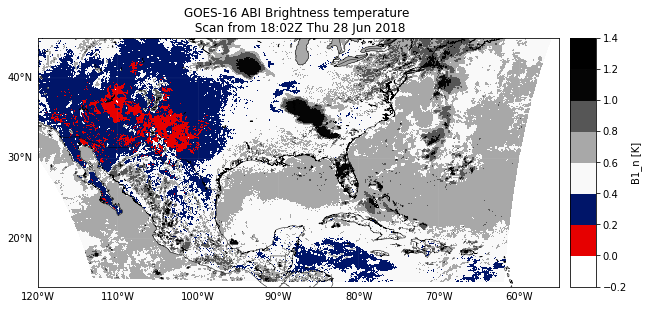

In [20]:
#DIFF normalizada:
DIFF = (data2_r-data1 ) /(data2_r+data1 )

#Banda 1 modificada:
B1_n = data1 - DIFF

lons_subset=lons[0:-1,0:-1]
lats_subset=lats[0:-1,0:-1]
data_subset= B1_n[0:-1,0:-1]

# Plot with zoomed domain for brightness temperature
bmap = Basemap(projection='cyl', llcrnrlon=-120, llcrnrlat=14, urcrnrlon=-55, urcrnrlat=45,  resolution='i')
# Plot GOES-16 Channel using 170 and 378 as the temperature thresholds
bmap.contourf(lons_subset,lats_subset,data_subset,cmap=cpt_convert)

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 10.0), linewidth=0.1, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.1, color='white', labels=[True, False, False, True])
# Insert the legend
bmap.colorbar(location='right', label='B1_n [K]')
date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("GOES-16 ABI Brightness temperature \n Scan from " +date_formatted)
# Show the plot
plt.rcParams['figure.figsize'] = (10,20)
plt.show()


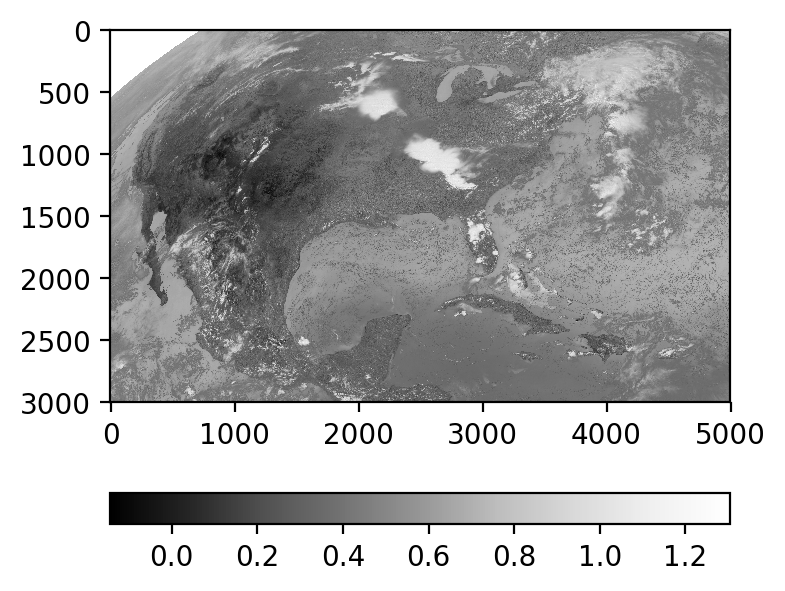

In [8]:
fig = plt.figure(figsize=(4,4),dpi=200)
im = plt.imshow(B1_n, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
#cb.set_label('Reflectance')
plt.show()

## Conclusión:

En la primera figura es posible apreciar que esta tranformación de los datos de la banda 1 es buena para detectar superficies muy brillantes (arenas) sobre el mar y sobre el continente, esto es evidente si se observan los desiertos del norte de México y el sur de EUA, además de la región azul en el sur de México, atribuibles al evento de arenas del Sahara. En esta misma imagen es posible apreciar que están bien diferenciadas las nubes (regiones negras) y los cuerpos de agua de las arenas (regiones rojas y azules). Adicionalmente al observar la imagen en tonos de grises es posible apreciar que el método está limitado por la presencia de nubes (al parecer bajas), esto es apreciable en regiones del territorio Mexicano que deberían ser reconocidos como arenas, pero son detectados como nubes (tonos grises claro). Por tanto este método parece funcionar para aerosoles de niveles altos de la atmósfera y para superficies despejadas.

# Validación del modelo:

## Método de Ackerman (1989) para detectar polvo

Propuso que las diferencias negativas entre las temperaturas de brillo de las bandas 3.7$\mu m$ y 11.7$\mu m$ son buenas para detectar arenas, lo anterior se debe a que al medir el índice de refracción del polvo se observa que existe una gran differencia entre las longitudes de onda de 3.7 $\mu m$ y 11 $\mu m$ y a que la parte imaginaria en 11 es dos ordenes de magnitud mayor que en 3.7. Por tanto este método es más sensible durante las horas del día, cuando la diferencia entre temperaturas se hace mayor debido al aumento de la reflección en el canal 3.7. 

En este caso los canales de GOES 16 más cercanos a  3.7 $\mu m$ y 11 $\mu m$ son 7 y 15 respectivamente. 


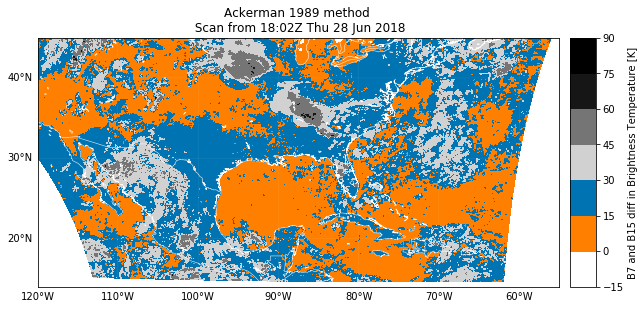

In [9]:
#chanel 7 :
path7 = '/home/olmo/Downloads/28062018/OR_ABI-L2-CMIPC-M3C07_G16_s20181791802194_e20181791804578_c20181791805041.nc'
nc7 = Dataset(path7)
data7 = nc7.variables['CMI'][:]
nc7.close()
#chanel 15:
path15 = '/home/olmo/Downloads/28062018/OR_ABI-L2-CMIPC-M3C15_G16_s20181791802194_e20181791804572_c20181791805040.nc'
nc15 = Dataset(path15)
data15 = nc15.variables['CMI'][:]

X = nc15.variables['x'][:] * sat_h
Y = nc15.variables['y'][:] * sat_h
nc15.close()
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

#DIFF :
newdata = (data7-data15)

lons_subset=lons[0:-1,0:-1]
lats_subset=lats[0:-1,0:-1]
data_subset=newdata[0:-1,0:-1]

# Plot with zoomed domain for brightness temperature
bmap = Basemap(projection='cyl', llcrnrlon=-120, llcrnrlat=14, urcrnrlon=-55, urcrnrlat=45,  resolution='i')
# Plot GOES-16 Channel using 170 and 378 as the temperature thresholds
bmap.contourf(lons_subset,lats_subset,data_subset,cmap=cpt_convert)

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='white')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='white')
bmap.drawparallels(np.arange(-90.0, 90.0, 10.0), linewidth=0.1, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.1, color='white', labels=[True, False, False, True])
# Insert the legend
bmap.colorbar(location='right', label='B7 and B15 diff in Brightness Temperature [K]')
date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("Ackerman 1989 method \n Scan from " +date_formatted)
# Show the plot
plt.rcParams['figure.figsize'] = (10,20)
plt.show()


## Conclusión:

Las mayores diferencias (colores oscuros y grises) representan las regiones donde se identifica la presencia de polvo, mientras que los tonos azules y naranjas la ausencia de éste. Si se compara con imágenes anteriores es evidente que las regiones no corresponden, pues marca como regiones de arenas regiones donde hay nubes, es decir no separa eficientemente entre distintos tipos de partículas reflejantes. No es un buen método para visualizar arenas. 

## Método de Qu et al. (2006):

### Normalized Dust Difference Index (NDDI) :

### NDDI = $\frac{\rho_{2.13} - \rho_{0.469}}{\rho_{2.13} + \rho_{0.469}}$ , 

donde $\rho_{2.13}$ y $\rho_{0.469}$ son la reflectancia en el tope de la atmósfera para las bandas 2.13$\mu m$ y 0.469$\mu m$, respectivamente. Para los datos de GOES 16 las bandas más cercanas son la banda 6, centrada en 2.25$\mu m$ y la banda 1, centrada en 0.47$\mu m$. En este caso utilizaremos los datos de radiancia de los canales 1 y 6, posteriormente serán transformados a reflectancia y finalmente se calculará y graficará el NDDI.




Nota:
reflectance constants --> NOAA at http://www.goes-r.gov/products/ATBDs/baseline/Imagery_v2.0_no_color.pdf on page 21.

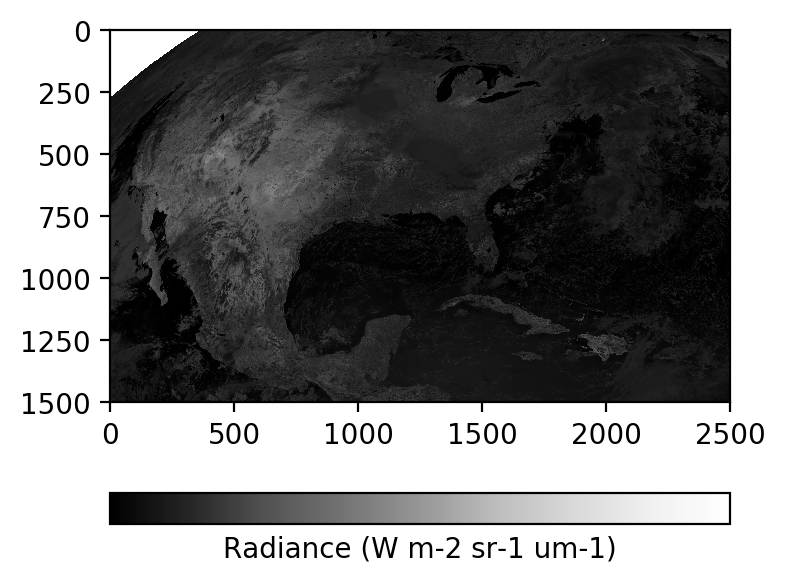

In [16]:
#Radiance canal 1:
path1 = '/home/olmo/Downloads/28062018/OR_ABI-L1b-RadC-M3C01_G16_s20181791802194_e20181791804567_c20181791805015.nc'
nc1 = Dataset(path1, 'r')
radiance1 = nc1.variables['Rad'][:]
nc1.close()

#Radiance canal 6:
path6 = '/home/olmo/Downloads/28062018/OR_ABI-L1b-RadC-M3C06_G16_s20181791802194_e20181791804572_c20181791805026.nc'
nc6 = Dataset(path6, 'r')
radiance6 = nc6.variables['Rad'][:]
nc6.close()

#calculo de reflectancia:
refl1 = reflectance(radiance1, band = 1)
refl6  = reflectance(radiance6, band = 6)

#remuestreo del canal 1:
ref_gamma1 = rebin(refl1, [1500, 2500])

#Calculo de NDDI:
NDDI = (refl6 - ref_gamma1)/(refl6 + ref_gamma1)

#Grafica:
fig = plt.figure(figsize=(4,4),dpi=200)
im = plt.imshow(NDDI, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.show()

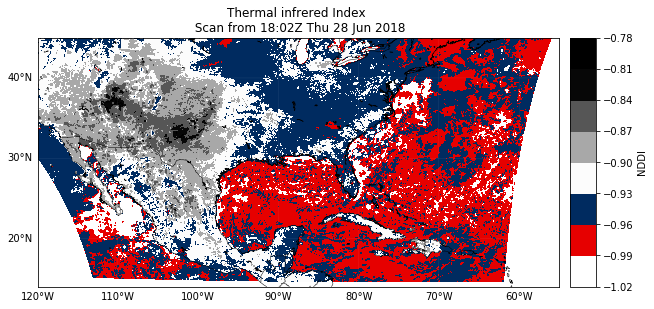

In [17]:
#Grafica2:
lons_subset=lons[0:-1,0:-1]
lats_subset=lats[0:-1,0:-1]
data_subset=NDDI[0:-1,0:-1]

# Plot with zoomed domain for brightness temperature
bmap = Basemap(projection='cyl', llcrnrlon=-120, llcrnrlat=14, urcrnrlon=-55, urcrnrlat=45,  resolution='i')
bmap.contourf(lons_subset,lats_subset,data_subset,cmap=cpt_convert)
# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 10.0), linewidth=0.1, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.1, color='white', labels=[True, False, False, True])
# Insert the legend
bmap.colorbar(location='right', label='NDDI')
date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("Thermal infrered Index \n Scan from " +date_formatted)
# Show the plot
plt.rcParams['figure.figsize'] = (10,20)
plt.show()

# Conclusión:

Se puede observar en la imagen en grises que este índice es bueno para retirar la capa de nubes frías, es decir separa bien entre los brillos del hielo y las arenas, sin embargo el contraste no es suficiente para evidenciarlas. En la segunda imagen los valores más altos (negros) representan las arenas. Este método es bueno para detectar las superficies deserticas, pero no para identificar arena sobre el oceano, quizá valdría la pena intentar quitar el efecto del vapor de agua de este índice. 

## Método de Hao and Qu (2007):

### Thermal Infrared Index (TDI) :

### TII = $c_0 + c_1 BT_{20} + c_2 BT_{30} + c_3 BT_{31} + c_4 BT_{32}$ , 

donde $BT$ es la temperatura de brillo con el subíndice representando el número de banda en MODIS. A continuación se muestran las bandas de MODIS con su ancho de banda en paréntesis, además se muestra el canal de GOES16 más cercano:

band --- MODIS  ---  nearest GOES band  

20  --- (3.660 - 3.840) --- 7

30  --- (9.580 - 9.880) --- 12

31  --- (10.780 - 11.280) -- 14

32  --- (11.770 - 12.270) -- 15


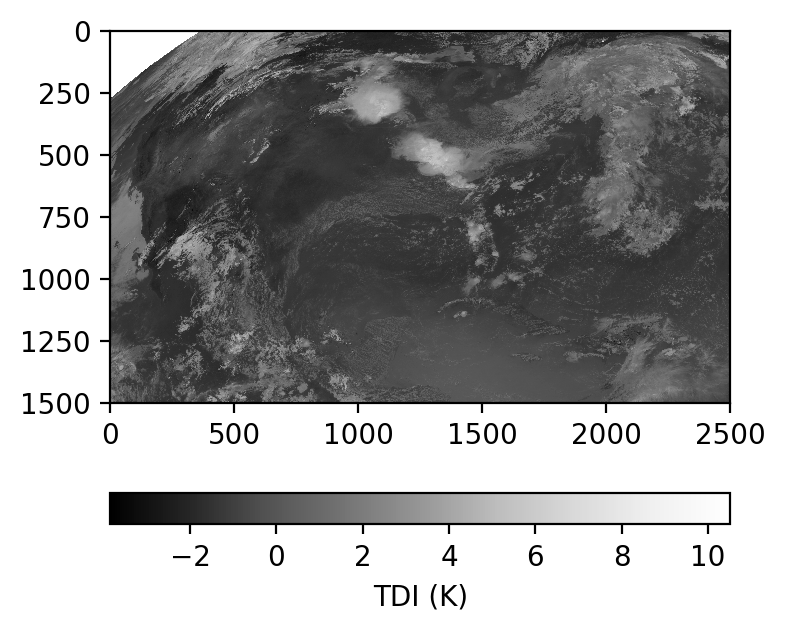

In [36]:
#chanel 7 :
data7 = data7 #previously loaded
#chanel 15 :
data15 = data15 
#chanel 12 :
path12 = '/home/olmo/Downloads/28062018/OR_ABI-L2-CMIPC-M3C12_G16_s20181791802194_e20181791804572_c20181791805031.nc'
nc12 = Dataset(path12)
data12 = nc12.variables['CMI'][:]
nc12.close()
#chanel 14 :
path14  = '/home/olmo/Downloads/28062018/OR_ABI-L2-CMIPC-M3C14_G16_s20181791802194_e20181791804567_c20181791805030.nc'
nc14  = Dataset(path14 )
data14  = nc14 .variables['CMI'][:]
nc14 .close()

# Calculo TDI:
c0 = -7.9370
c1 = 0.1227
c2 = 0.0260
c3 = -0.7068
c4 = 0.5883
TDI = c0 + c1*data7 + c2*data12 + c3*data14 +c4*data15

#Grafica1:
fig = plt.figure(figsize=(4,4),dpi=200)
im = plt.imshow(TDI, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
#cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('TDI (K)')
plt.show()

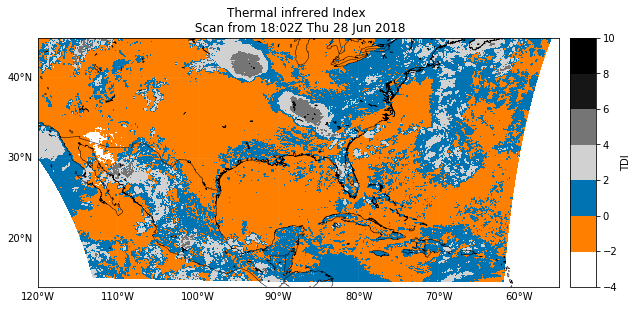

In [37]:
#Grafica2:
lons_subset=lons[0:-1,0:-1]
lats_subset=lats[0:-1,0:-1]
data_subset=TDI[0:-1,0:-1]

# Plot with zoomed domain for brightness temperature
bmap = Basemap(projection='cyl', llcrnrlon=-120, llcrnrlat=14, urcrnrlon=-55, urcrnrlat=45,  resolution='i')
bmap.contourf(lons_subset,lats_subset,data_subset,cmap=cpt_convert)
# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 10.0), linewidth=0.1, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.1, color='white', labels=[True, False, False, True])
# Insert the legend
bmap.colorbar(location='right', label='TDI')
date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("Thermal infrered Index \n Scan from " +date_formatted)
# Show the plot
plt.rcParams['figure.figsize'] = (10,20)
plt.show()

# Conclusión

La imagen en blanco y negro muestra una región borrosa que podría atribuirse al polvo del sahara, pues no hay nubes cercanas y no parece ser vapor de agua. En regiones gris oscuro aparecen nubes frías, en azul se muestran otras regiones muy brillosas y no logra distinguir entre las nubes y la arena. Se debe de tener cautela con estos resultados, debido a que las constantes utilizadas corresponden a los canales de MODIS y los resultados pueden ser muy sensibles, este método podría implementarse investigando las constantes para GOES16. 

# Conclusión general

El método propuesto es una buena opción para detectar arenas en superficies despejadas y en altos niveles de la atmósfera. En combinación con un método que sea bueno para ver la superficie (i.e. Qu et al.), podría utilizarse para mejorar la visualización. 

# Bibliografía consultada

Ackerman SA, (1989), Using the radiative temperature difference at 3.7 μm and 11 μm to trace dust outbreaks. Remote Sensing Environment,27:129–133.

Qu JJ, Hao X, Kafatos M, Wang L, (2006), Asian Dust Storm Monitoring Combining Terra and Aqua MODIS SRB Measurements. IEEE Geoscience and Remote Sensing Letter, 3(4):484–486.

Hao X, Qu JJ, (2007), Saharan dust storm detection using moderate resolution imaging spectroradiometer thermal infrared bands. J Appl Remote Sens, 1:013510.

Mehdi Samadi, Ali Darvishi Boloorani , Seyed Kazem Alavipanah , Hossein Mohamadi and Mohamad Saeed Najafi, 2014, Global dust Detection Index (GDDI); a new remotely sensed methodology for dust storms detection, Journal of Environmental Health Science & Engineering,12:20.